In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 2
(11 points)

**a)** In this problem we will study a **structural time series** model.
$$
    \begin{cases} \alpha_t = T \alpha_{t-1} + R \eta_t, & \eta_t \sim \mathcal{N}(0,Q), \\ y_t = Z \alpha_t + \varepsilon_t, & \varepsilon_t \sim \mathcal{N}(0,H), \end{cases}
$$
where $\alpha_t$ contains a trend and seasonal part.
The trend in this model is **linear** but the seasonality is unknown.
We let the variances of the model be $\sigma_{\mu}^2 = 0.1^2$, $\sigma_{\gamma}^2 = 0.1^2$, and $\sigma_{\varepsilon}^2 = 1$.

The data file `data_problem2.csv` contains a sequence of observations from this model over a few years. Using this data you are tasked to do the following:

1. Look at the provided data and find the seasonality $s$.
2. Setup the complete model by writing down the matrices $T$, $R$, $Q$, $Z$, and $H$. Also specify your hidden states $\alpha_t$. Remember to motivate your choices of matrices.
3. Set up the mean vector of the initial distribution such that 
    * The trend component starts at the first observation,
    * The slope of the trend is _a priori_ zero in expectation,
    * The initial mean of all states related to the seasonal component are zero.
4. Set up the initial covariance matrix as a diagonal matrix with 100 on the diagonal.

<div style="text-align: right"> (4p) </div>

In [50]:
data = pd.read_csv('data_problem2.csv',header=0)
y = data['Data'].values
u = data['Dates'].values

from tssltools import LGSS

**Solution:**

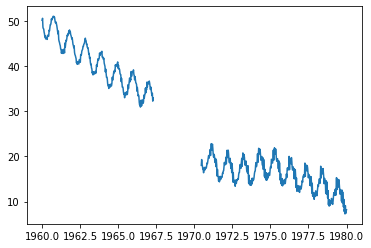

In [51]:
plt.plot(u,y)
plt.show()
# u[39:80]
# s = 39?

In [54]:
from scipy.linalg import block_diag
# 2 ######################################################################
s = 39

T_mu = np.ndarray(shape=(2,2), buffer = np.array([2,-1, 1, 0]),dtype=int)
R_mu = np.ndarray(shape=(2,1), buffer = np.array([1,0]),dtype=int)
Z_mu = np.ndarray(shape=(1,2), buffer = np.array([1,0]),dtype=int)

print(T_mu)
print(R_mu)
print(Z_mu)

T_gamma = np.zeros([s-1,s-1])
T_gamma[0] = -1
T_gamma[1:,0:(s-1-1)] = np.identity(s-1-1)

R_gamma = np.zeros([s-1,1])
R_gamma[0] = 1

Z_gamma = np.zeros([1,s-1])
Z_gamma[0] = 1

#print(T_gamma)
#print(R_gamma)
#print(Z_gamma)

T = block_diag(T_mu, T_gamma)
R = block_diag(R_mu, R_gamma)
Z = np.concatenate((Z_mu, Z_gamma), axis = 1)

print(T.shape)
print(R.shape)
print(Z.shape)

sigma_trend = 0.1
sigma_seas = 0.1
sigma_eps = 1

Q = np.array([[sigma_trend**2, 0], [0, sigma_seas**2]])
H = sigma_eps
print(Q)


[[ 2 -1]
 [ 1  0]]
[[1]
 [0]]
[[1 0]]
(40, 40)
(40, 2)
(1, 40)
[[0.01 0.  ]
 [0.   0.01]]


In [58]:
# 3 ####################################
a1 = np.zeros([40, 1])
a1[0] = y[0]
a1[1] = y[0]


# 4 ####################################
P1 = np.diag(np.ones(40)) * 100
P1

array([[50.1012644],
       [50.1012644],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ],
       [ 0.       ]])

___

**b)** When performing inference in a structural time series model we are interested in the distribution of the hidden states given the data. You find your implementation of the Kalman filter but unfortunately some parts of the code is missing, to fix this you should do the following:

1. Derive the conditional distribution of $\alpha_{t+1} \mid \alpha_t, y_{1:t}$.
2. Use these results to compelte the implementation of the Kalman filter below. 

<div style="text-align: right"> (3p) </div>

**Solution:**

In [56]:
from tssltools import kfs_res

def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)
    F_pred = np.zeros(n)

    T, R, Q, Z, H, a1, P1 = model.get_params() 

    for t in range(n):
        # Time update (predict)
        if t == 0:  
            alpha_pred[:, 0, 0] = a1 
            P_pred[:, :, 0] = P1
        else:
            ##############################
            # ADD CODE HERE:
            alpha_pred[:, :, t] = T @ alpha_filt[:,:,t-1]
            TPT = (T @ P_filt[:,:,t-1]) @ np.transpose(T)
            RQT = (R @ Q) @ np.transpose(R)
            P_pred[:, :, t] = TPT + RQT
            ###############################

        # Compute prediction of current output
        y_pred[t] = Z @ alpha_pred[:, :, t]
        F_pred[t] = Z @ P_pred[:, :, t] @ Z.T + H

        # Measurement update
        if np.isnan(y[t]):
            alpha_filt[:, :, t] = alpha_pred[:, :, t].copy()
            P_filt[:, :, t] = P_pred[:, :, t].copy()
        else:
            K = P_pred[:, :, t] @ Z.T / F_pred[t]
            alpha_filt[:, :, t] = alpha_pred[:, :, t] + K * (y[t] - y_pred[t])
            P_filt[:, :, t] = (np.identity(d) - K @ Z) @ P_pred[:, :, t]

    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf

___

**c)** As you look into the data you may have noticed that some data-points are missing, you are interested in trying to estimate this missing sequence.

For this task you should do the following:

1. Run the Kalman filter and Kalman smoother on the data.
2. Generate a plot showing the data, the filtered estimates $\mathbb{E}[Z \alpha_t \mid y_{1:t}]$ and the smoothed estimates $\mathbb{E}[Z \alpha_t \mid y_{1:n}]$ for all $t$.
3. For both the filter and smoothing estiamtes you should add $\pm 1$ standard deviation.
4. Discuss the difference between the estimates (both mean and standard deviation) of the filter and the smoother.

<div style="text-align: right"> (4p) </div>

**Solution:**

(791,)
(791,)


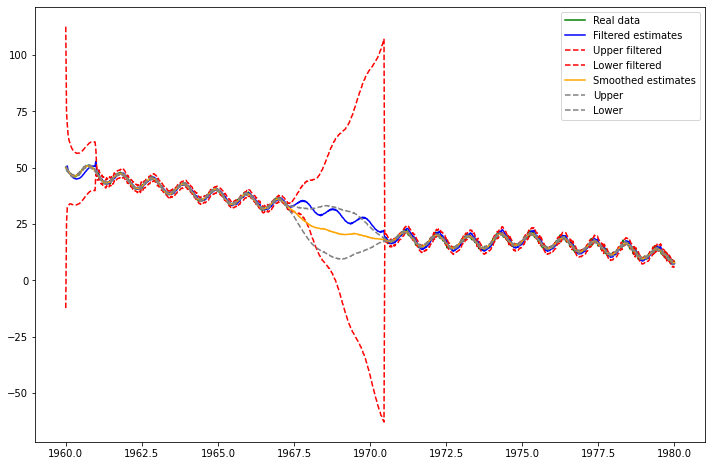

In [74]:
plt.rcParams["figure.figsize"] = (12,8)  # Increase default size of plots
from tssltools import LGSS, kalman_smoother
# 1 #####################################
a1 = a1.flatten()
model = LGSS(T, R, Q, Z, H, a1, P1)
kf = kalman_filter(y = y, model = model)
ks = kalman_smoother(y = y, model = model, kf = kf)
#print(ks.alpha_sm.shape)
smooth_pred = (Z @ ks.alpha_sm.reshape(40, 791)).flatten()
smooth_var = (Z @ ks.V.T @ Z.T).flatten()

print(u.shape)
print(kf.y_pred.shape)

# 2 & 3#####################################
plt.plot(u, y, label = "Real data", color="green")
plt.plot(u, kf.y_pred, label = "Filtered estimates", color="blue")
plt.plot(u, kf.y_pred + np.sqrt(kf.F_pred), label = "Upper filtered", linestyle='--', color = "red")
plt.plot(u, kf.y_pred - np.sqrt(kf.F_pred), label = "Lower filtered", linestyle='--', color = "red")

plt.plot(u ,smooth_pred, label = "Smoothed estimates", color="orange")
plt.plot(u, smooth_pred + np.sqrt(smooth_var), label = "Upper", linestyle='--', color = "grey")
plt.plot(u, smooth_pred - np.sqrt(smooth_var), label = "Lower", linestyle='--', color = "grey")
plt.legend()
plt.show()
